In [49]:
from dotenv import load_dotenv
from pprint import pprint
from typing import TypedDict, Annotated

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain.globals import *
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage

from langchain_openai import ChatOpenAI

load_dotenv()

class MessagesState(MessagesState):
    pass

llm = ChatOpenAI(model="gpt-4o")

In [41]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [multiply, add, divide]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=True)

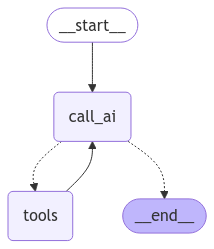

In [51]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def call_ai(state: MessagesState):
    return {"messages": llm_with_tools.invoke([sys_msg] + state["messages"])}

builder = StateGraph(MessagesState)
builder.add_node(call_ai)
builder.add_node(ToolNode(tools))

builder.add_edge(START, "call_ai")
builder.add_conditional_edges("call_ai", tools_condition)
builder.add_edge("tools", "call_ai")

graph = builder.compile(checkpointer=MemorySaver())
graph

In [56]:
config = {"configurable": {"thread_id": "1"}}
messages = [HumanMessage(content="Divide by 2")]
result = graph.invoke(MessagesState(messages=messages), config=config)
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

My name is Bob.
================================ Human Message =================================

What is 2 times 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_MEDc9VZv5VKoGN4NK02d0MXD)
 Call ID: call_MEDc9VZv5VKoGN4NK02d0MXD
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2 times 3 is 6.
================================ Human Message =================================

What's my name?
================================== Ai Message ==================================

Your name is Bob.
================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_1M1fz